In [21]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Load data

In [22]:
dataset_folders = [
    'datasets/twitter-roberta-base-sentiment',
    'datasets/twitter-xlm-roberta-base-sentiment',
    'datasets/wine_1',
    'datasets/spam_detection_1',
    'datasets/spam_detection_2',
    'datasets/spam_detection_3',
    'datasets/spam_detection_4',
    'datasets/spam_detection_5',
    'datasets/spam_detection_6',
]

features = [
    'threshold',
    'params_reduction_pct',
    'num_classes',
    'accuracy',
]

df = pd.DataFrame()
for idx, folder in enumerate(dataset_folders):
    df_full = pd.read_csv(f'{folder}/pruning_threshold_results.csv')
    df_temp = df_full[['threshold', 'flops', 'params_reduction_pct', 'non_zero_params', 'overall_accuracy']]
    df_temp = df_temp.rename(columns={'overall_accuracy': 'accuracy', 'flops': 'FLOPS'})
    df_temp['threshold'] = pd.to_numeric(df_temp['threshold'], errors='coerce')
    df_temp['model_id'] = idx

    # Calculate the number of classes based on the count of *_accuracy columns
    num_classes = len([col for col in df_full.columns if col.endswith('_accuracy')]) - 1
    df_temp['num_classes'] = num_classes

    df_temp = df_temp.dropna()
    df = pd.concat([df, df_temp], ignore_index=True)

df = df[features + ['model_id']]

df.head()

,threshold,params_reduction_pct,num_classes,accuracy,model_id
0,0.0,0.000000,3,0.717035,0
1,0.1,1.554351,3,0.717883,0
2,0.2,3.102511,3,0.718166,0
3,0.3,4.642797,3,0.718449,0
4,0.4,6.166902,3,0.717883,0


## Prepare the input data and labels

In [24]:
X_all = []
y_all = []
model_ids = []

for model_id, data in df.groupby('model_id'):
    data = data.sort_values('threshold')
    
    for i in range(1, len(data)):
        prev_row = data.iloc[i-1]
        curr_row = data.iloc[i]
        last_row = data.iloc[-1]
        
        X = [
            curr_row['threshold'],
            curr_row['params_reduction_pct'],
            curr_row['num_classes'],
            prev_row['accuracy'],
            last_row['accuracy'],
        ]
        
        # Target is now the CHANGE in accuracy
        y = curr_row['accuracy'] - prev_row['accuracy']
        
        X_all.append(X)
        y_all.append(y)
        model_ids.append(model_id)

X = np.array(X_all)
y = np.array(y_all).reshape(-1, 1)
model_ids = np.array(model_ids)

## Scale the data

In [25]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

## Predict an entire sequence

In [26]:
def predict_sequential_thresholds_delta(model, initial_data, thresholds, scaler_X, scaler_y):
    predictions = []
    current_accuracy = initial_data['initial_accuracy']
    
    for threshold in thresholds:
        features = [
            threshold,
            initial_data['params_reduction_pct'],
            initial_data['num_classes'],
            current_accuracy,
            initial_data['final_accuracy'],
        ]
        
        # Scale and predict the CHANGE in accuracy
        features_scaled = scaler_X.transform([features])
        features_reshaped = features_scaled.reshape(1, 1, features_scaled.shape[1])
        delta_scaled = model.predict(features_reshaped, verbose=0)
        delta = scaler_y.inverse_transform(delta_scaled)[0][0]
        
        # Apply the change to get new accuracy
        new_accuracy = current_accuracy + delta
        predictions.append(new_accuracy)
        current_accuracy = new_accuracy
    
    return predictions

# Leave one group out cross-validation

In [27]:
logo = LeaveOneGroupOut()
all_model_errors = []
all_thresholds = np.arange(0.1, 3.1, 0.1)  # Thresholds from 0.1 to 3.0 in steps of 0.1

# Store actual vs predicted values for plotting
all_actual_curves = []
all_predicted_curves = []
all_model_ids_test = []

for train_val_idx, test_idx in logo.split(X_scaled, y_scaled, groups=model_ids):
    X_train_val = X_scaled[train_val_idx]
    y_train_val = y_scaled[train_val_idx]
    model_ids_train_val = model_ids[train_val_idx]
    
    # From the training+validation set, select one model for validation
    unique_train_val_models = np.unique(model_ids_train_val)
    val_model_id = np.random.choice(unique_train_val_models, size=1)[0]
    
    # Create masks for train and validation
    val_mask = model_ids_train_val == val_model_id
    train_mask = ~val_mask
    
    # Final split
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    X_test = X_scaled[test_idx]
    y_test = y_scaled[test_idx]
    
    # Reshape data for LSTM
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    # Define and train model
    input_dim = X_train.shape[1]
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.1),
        LSTM(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=150,
        batch_size=32,
        validation_data=(X_val_reshaped, y_val),
        verbose=1
    )
    
    # Get the test model ID
    test_model_id = model_ids[test_idx][0]
    all_model_ids_test.append(test_model_id)
    
    # Get initial data for this test model from the original dataframe
    test_model_data = df[df['model_id'] == test_model_id].sort_values('threshold')
    initial_data = {
        'params_reduction_pct': test_model_data.iloc[0]['params_reduction_pct'],
        'initial_accuracy': test_model_data.iloc[0]['accuracy'],
        'num_classes': test_model_data.iloc[0]['num_classes'],
        'final_accuracy': test_model_data.iloc[-1]['accuracy'],
    }
    
    # Make sequential predictions for all thresholds
    predicted_accuracies = predict_sequential_thresholds_delta(
        model, initial_data, all_thresholds, scaler_X, scaler_y
    )
    
    # Get actual accuracies for comparison (from original dataframe)
    actual_accuracies = []
    for threshold in all_thresholds:
        # Find closest threshold in the original data
        closest_row = test_model_data.iloc[(test_model_data['threshold'] - threshold).abs().argsort()[:1]]
        actual_accuracies.append(closest_row['accuracy'].values[0])
    
    # Calculate mean absolute error for this model
    model_error = np.mean(np.abs(np.array(actual_accuracies) - np.array(predicted_accuracies)))
    all_model_errors.append(model_error)
    
    # Store actual and predicted curves for plotting
    all_actual_curves.append(actual_accuracies)
    all_predicted_curves.append(predicted_accuracies)
    
    print(f"Model {test_model_id} - Mean Absolute Error: {model_error:.4f}")

# Calculate overall error
overall_mae = np.mean(all_model_errors)
print(f"\nOverall Mean Absolute Error across all models: {overall_mae:.4f}")

Epoch 1/150


/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4974 - val_loss: 0.2804
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4384 - val_loss: 0.2370
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4506 - val_loss: 0.1772
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4164 - val_loss: 0.0908
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3519 - val_loss: 0.0601
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3769 - val_loss: 0.0537
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3559 - val_loss: 0.0533
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4343 - val_loss: 0.0507
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3299 - val_loss: 0.0438
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4574 - val_loss: 0.0389
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4273 - val_loss: 0.0403
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3476 - val_loss: 0.0406
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.5863 - val_loss: 0.2530
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4619 - val_loss: 0.1789
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4765 - val_loss: 0.0790
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3198 - val_loss: 0.0611
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4246 - val_loss: 0.0522
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3915 - val_loss: 0.0552
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3347 - val_loss: 0.0500
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3359 - val_loss: 0.0426
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3589 - val_loss: 0.0422
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3141 - val_loss: 0.0447
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3690 - val_loss: 0.0397
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3977 - val_loss: 0.0361
Epoch 13/1

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.5575 - val_loss: 0.2437
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5892 - val_loss: 0.1992
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6327 - val_loss: 0.1370
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4622 - val_loss: 0.0673
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4379 - val_loss: 0.0934
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4946 - val_loss: 0.0620
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3984 - val_loss: 0.0640
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4067 - val_loss: 0.0626
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4374 - val_loss: 0.0590
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5365 - val_loss: 0.0604
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4610 - val_loss: 0.0653
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4099 - val_loss: 0.0583
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.5136 - val_loss: 0.9154
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4809 - val_loss: 0.8923
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3910 - val_loss: 0.8650
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3995 - val_loss: 0.8444
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4274 - val_loss: 0.8467
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3194 - val_loss: 0.8456
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2693 - val_loss: 0.8450
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3514 - val_loss: 0.8465
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3269 - val_loss: 0.8472
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2796 - val_loss: 0.8469
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3536 - val_loss: 0.8466
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3103 - val_loss: 0.8482
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.5037 - val_loss: 0.6685
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4282 - val_loss: 0.6447
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4437 - val_loss: 0.6173
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4982 - val_loss: 0.6009
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3039 - val_loss: 0.6094
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3749 - val_loss: 0.6001
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4127 - val_loss: 0.6000
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3840 - val_loss: 0.6010
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3611 - val_loss: 0.6000
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3739 - val_loss: 0.5998
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4162 - val_loss: 0.6042
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3372 - val_loss: 0.6003
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.5520 - val_loss: 0.2285
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4595 - val_loss: 0.1842
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3617 - val_loss: 0.1381
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3934 - val_loss: 0.1489
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3240 - val_loss: 0.1520
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3281 - val_loss: 0.1343
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2932 - val_loss: 0.1385
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3609 - val_loss: 0.1442
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2963 - val_loss: 0.1406
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3219 - val_loss: 0.1359
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2944 - val_loss: 0.1375
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3490 - val_loss: 0.1361
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.5669 - val_loss: 0.2466
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5683 - val_loss: 0.2099
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5362 - val_loss: 0.1607
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4805 - val_loss: 0.0999
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4553 - val_loss: 0.0653
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4168 - val_loss: 0.0626
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4949 - val_loss: 0.0664
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4213 - val_loss: 0.0631
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4461 - val_loss: 0.0574
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4888 - val_loss: 0.0577
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4504 - val_loss: 0.0621
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3991 - val_loss: 0.0597
Epoch 13/1

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.5634 - val_loss: 0.6517
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4839 - val_loss: 0.6373
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3731 - val_loss: 0.6177
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4133 - val_loss: 0.5956
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4155 - val_loss: 0.5891
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3430 - val_loss: 0.5883
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3849 - val_loss: 0.5944
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3526 - val_loss: 0.5915
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3764 - val_loss: 0.5895
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3169 - val_loss: 0.5900
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3782 - val_loss: 0.5890
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2783 - val_loss: 0.5871
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4907 - val_loss: 0.2641
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4470 - val_loss: 0.1940
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4151 - val_loss: 0.1014
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3433 - val_loss: 0.0565
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4036 - val_loss: 0.0542
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3104 - val_loss: 0.0583
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3651 - val_loss: 0.0558
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3438 - val_loss: 0.0469
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3094 - val_loss: 0.0449
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3009 - val_loss: 0.0449
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3887 - val_loss: 0.0436
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3269 - val_loss: 0.0379
Epoch 13/150

## Plot the results

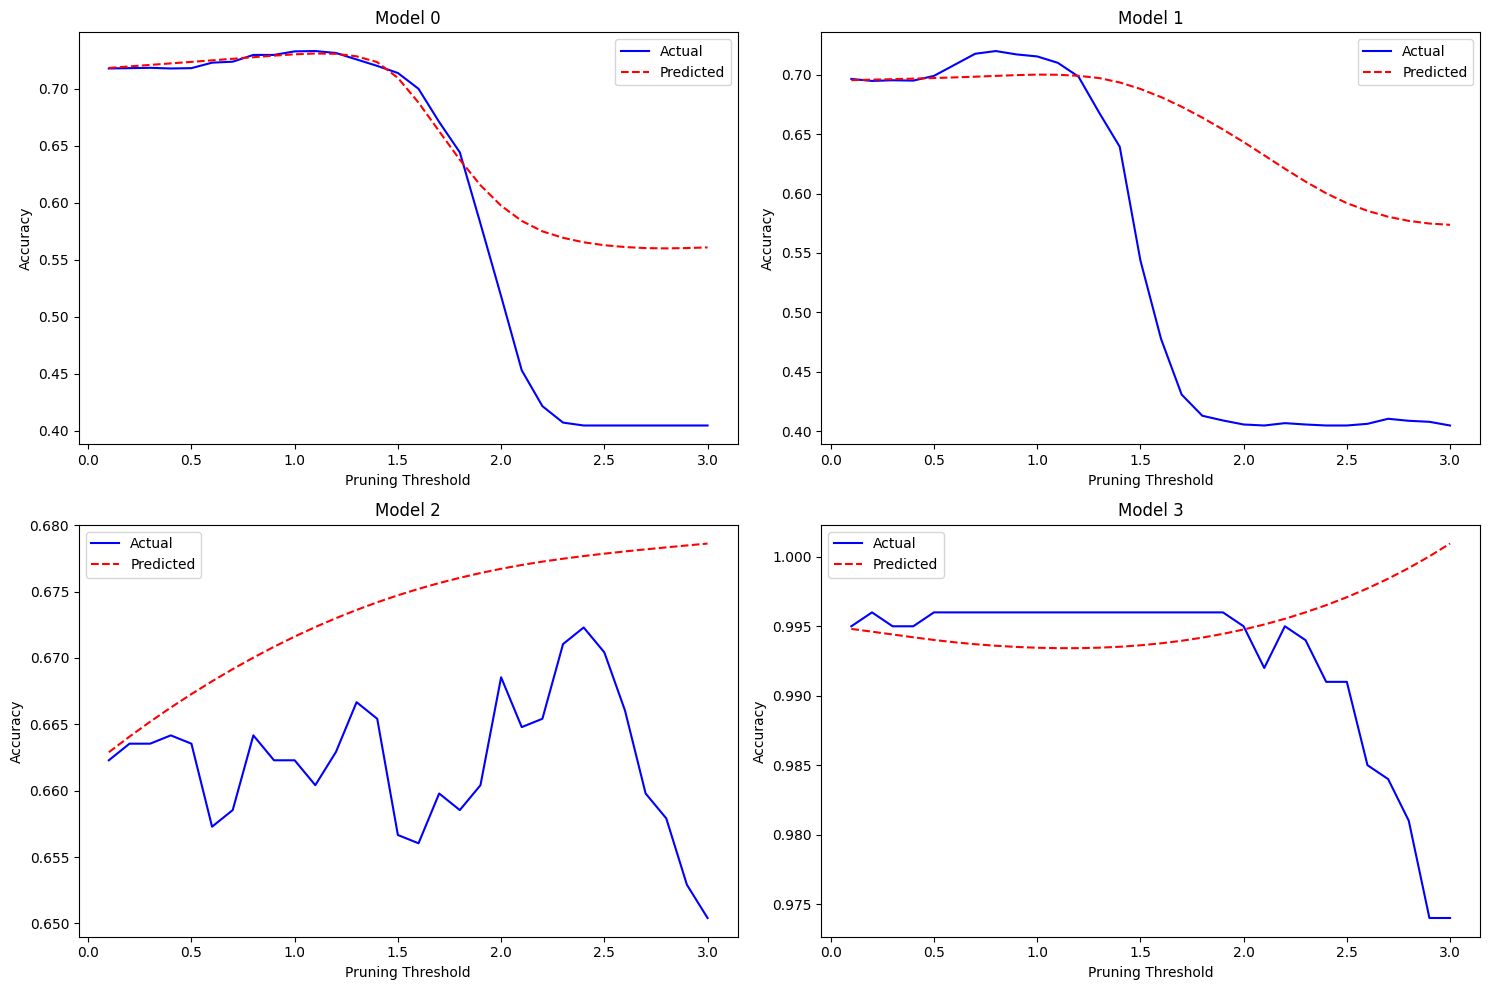

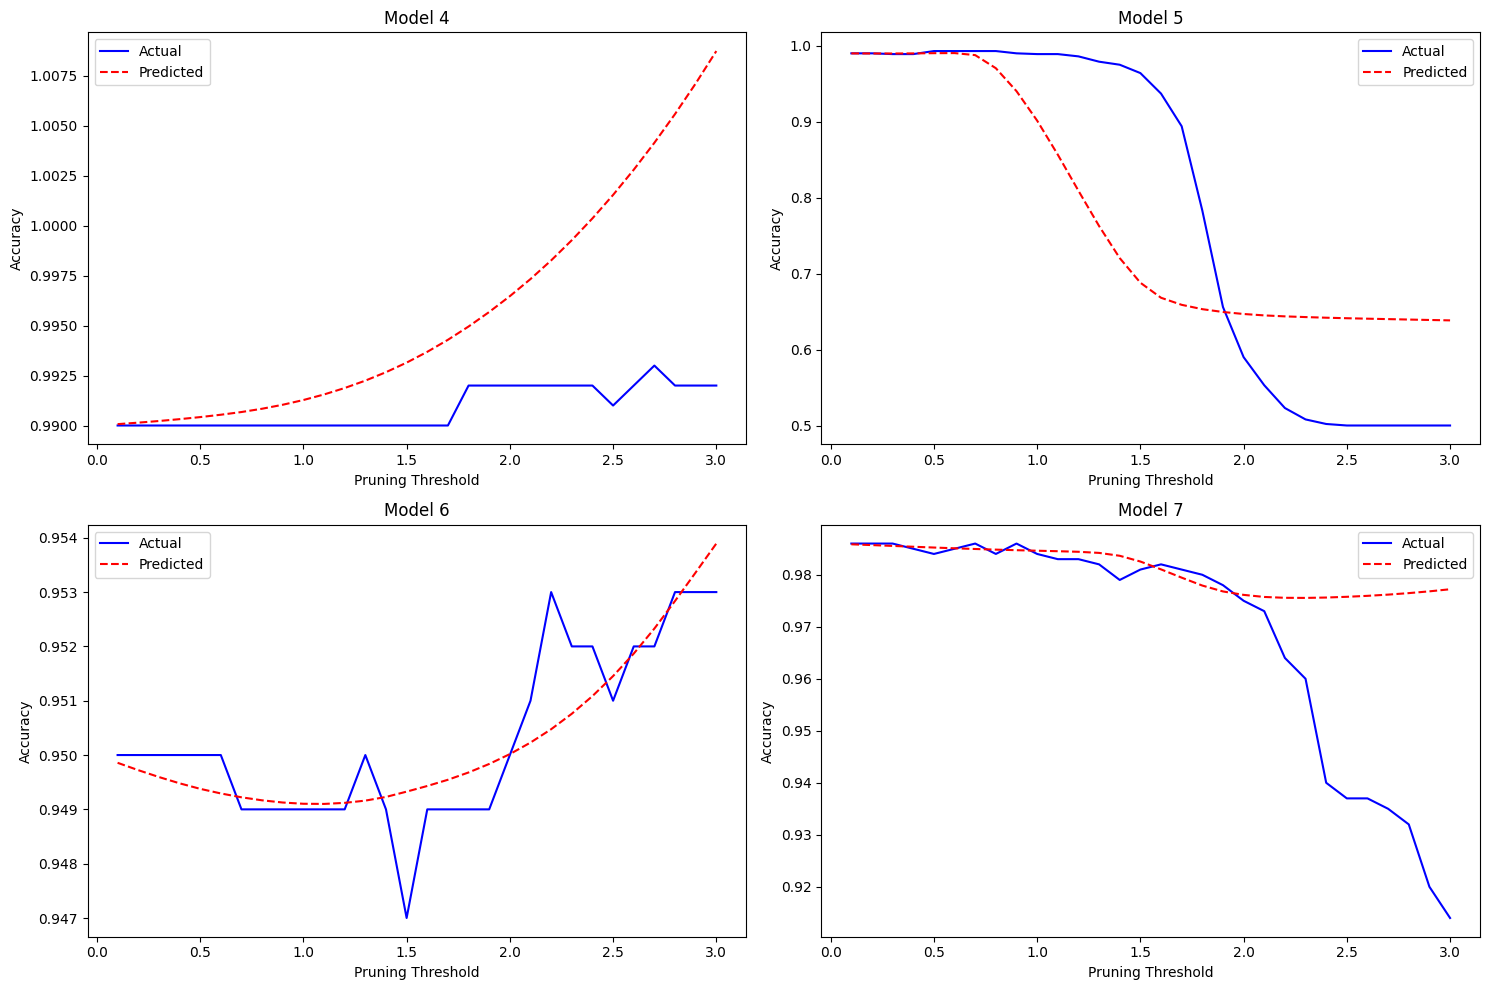

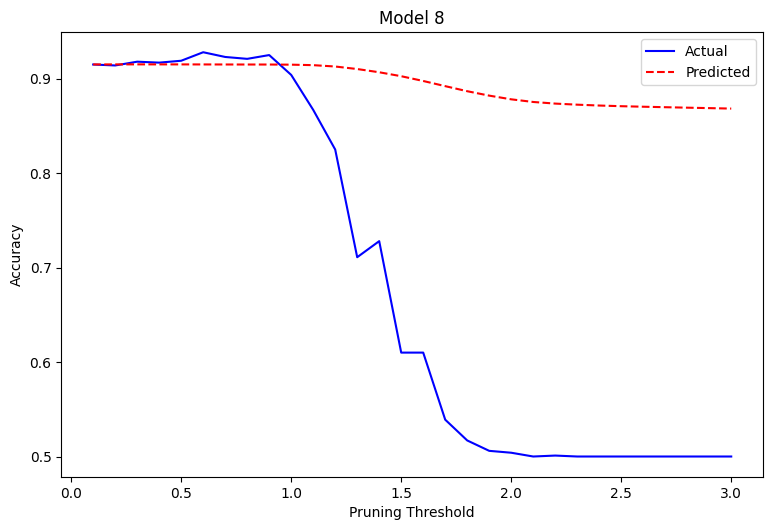

In [28]:
plt.figure(figsize=(15, 10))
for i in range(len(all_model_ids_test)):
    plt.subplot(2, 2, i % 4 + 1)
    plt.plot(all_thresholds, all_actual_curves[i], 'b-', label='Actual')
    plt.plot(all_thresholds, all_predicted_curves[i], 'r--', label='Predicted')
    plt.title(f'Model {all_model_ids_test[i]}')
    plt.xlabel('Pruning Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    
    if (i + 1) % 4 == 0 or i == len(all_model_ids_test) - 1:
        plt.tight_layout()
        plt.show()
        if i < len(all_model_ids_test) - 1:
            plt.figure(figsize=(15, 10))

## Cliff detector

In [31]:
# Extract critical thresholds from training data
critical_features = []
critical_thresholds = []

for model_id, data in df.groupby('model_id'):
    data = data.sort_values('threshold')
    accuracies = data['accuracy'].values
    thresholds = data['threshold'].values
    
    # Calculate rate of change in accuracy
    accuracy_diff = np.diff(accuracies)
    
    # Find the point of maximum accuracy drop
    if len(accuracy_diff) > 0:
        max_drop_idx = np.argmin(accuracy_diff)
        critical_threshold = thresholds[max_drop_idx + 1]
        
        # Feature vector for this model (use whatever features you have)
        model_features = [
            data.iloc[0]['params_reduction_pct'],
            data.iloc[0]['num_classes'],
            data.iloc[-1]['accuracy'],  # Final accuracy
            data.iloc[0]['accuracy']  # Starting accuracy
        ]
        
        critical_features.append(model_features)
        critical_thresholds.append(critical_threshold)

# Train a model to predict the critical threshold
from sklearn.ensemble import RandomForestRegressor
cliff_detector = RandomForestRegressor(n_estimators=100)
cliff_detector.fit(critical_features, critical_thresholds)

RandomForestRegressor()

In [32]:
def hybrid_predict(lstm_model, cliff_detector, initial_data, thresholds, scaler_X, scaler_y):
    # Predict the critical threshold where accuracy will drop
    model_features = [
        initial_data['params_reduction_pct'],
        initial_data['initial_accuracy'],
        initial_data['num_classes'],
        initial_data['final_accuracy'],
    ]
    critical_threshold = cliff_detector.predict([model_features])[0]
    
    # Make initial LSTM predictions
    lstm_predictions = predict_sequential_thresholds_delta(lstm_model, initial_data, thresholds, scaler_X, scaler_y)
    
    # Apply the parametric "plateau-then-cliff" model
    hybrid_predictions = []
    for i, threshold in enumerate(thresholds):
        if threshold < critical_threshold - 0.2:
            # Before cliff: maintain a plateau close to initial accuracy
            hybrid_predictions.append(initial_data['initial_accuracy'] * 0.98)
        elif threshold > critical_threshold + 0.2:
            # After cliff: low accuracy
            min_accuracy = 0.4  # Set based on your data
            hybrid_predictions.append(min_accuracy)
        else:
            # During transition: linear interpolation
            progress = (threshold - (critical_threshold - 0.2)) / 0.4
            start_acc = initial_data['initial_accuracy'] * 0.98
            end_acc = 0.4
            hybrid_predictions.append(start_acc + progress * (end_acc - start_acc))
    
    # Blend the two predictions (with emphasis on parametric model)
    final_predictions = []
    for i in range(len(thresholds)):
        # Weight more toward parametric model
        blended = 0.2 * lstm_predictions[i] + 0.8 * hybrid_predictions[i]
        final_predictions.append(blended)
    
    return final_predictions

In [33]:
logo = LeaveOneGroupOut()
all_model_errors = []
all_thresholds = np.arange(0.1, 3.1, 0.1)  # Thresholds from 0.1 to 3.0 in steps of 0.1

# Store actual vs predicted values for plotting
all_actual_curves = []
all_predicted_curves = []
all_model_ids_test = []

for train_val_idx, test_idx in logo.split(X_scaled, y_scaled, groups=model_ids):
    X_train_val = X_scaled[train_val_idx]
    y_train_val = y_scaled[train_val_idx]
    model_ids_train_val = model_ids[train_val_idx]
    
    # From the training+validation set, select one model for validation
    unique_train_val_models = np.unique(model_ids_train_val)
    val_model_id = np.random.choice(unique_train_val_models, size=1)[0]
    
    # Create masks for train and validation
    val_mask = model_ids_train_val == val_model_id
    train_mask = ~val_mask
    
    # Final split
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    X_test = X_scaled[test_idx]
    y_test = y_scaled[test_idx]
    
    # Reshape data for LSTM
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    # Define and train model
    input_dim = X_train.shape[1]
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.1),
        LSTM(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=150,
        batch_size=32,
        validation_data=(X_val_reshaped, y_val),
        verbose=1
    )
    
    # Get the test model ID
    test_model_id = model_ids[test_idx][0]
    all_model_ids_test.append(test_model_id)
    
    # Get initial data for this test model from the original dataframe
    test_model_data = df[df['model_id'] == test_model_id].sort_values('threshold')
    initial_data = {
        'params_reduction_pct': test_model_data.iloc[0]['params_reduction_pct'],
        'initial_accuracy': test_model_data.iloc[0]['accuracy'],
        'num_classes': test_model_data.iloc[0]['num_classes'],
        'final_accuracy': test_model_data.iloc[-1]['accuracy'],
    }
    
    # Make sequential predictions for all thresholds
    predicted_accuracies = hybrid_predict(
        model, cliff_detector, initial_data, all_thresholds, scaler_X, scaler_y
    )
    
    # Get actual accuracies for comparison (from original dataframe)
    actual_accuracies = []
    for threshold in all_thresholds:
        # Find closest threshold in the original data
        closest_row = test_model_data.iloc[(test_model_data['threshold'] - threshold).abs().argsort()[:1]]
        actual_accuracies.append(closest_row['accuracy'].values[0])
    
    # Calculate mean absolute error for this model
    model_error = np.mean(np.abs(np.array(actual_accuracies) - np.array(predicted_accuracies)))
    all_model_errors.append(model_error)
    
    # Store actual and predicted curves for plotting
    all_actual_curves.append(actual_accuracies)
    all_predicted_curves.append(predicted_accuracies)
    
    print(f"Model {test_model_id} - Mean Absolute Error: {model_error:.4f}")

# Calculate overall error
overall_mae = np.mean(all_model_errors)
print(f"\nOverall Mean Absolute Error across all models: {overall_mae:.4f}")

Epoch 1/150


/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5359 - val_loss: 0.2247
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5423 - val_loss: 0.1575
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4659 - val_loss: 0.0795
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4162 - val_loss: 0.0843
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4312 - val_loss: 0.0618
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3073 - val_loss: 0.0647
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4138 - val_loss: 0.0587
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3743 - val_loss: 0.0574
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3680 - val_loss: 0.0587
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3783 - val_loss: 0.0604
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4370 - val_loss: 0.0560
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4017 - val_loss: 0.0563
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.5292 - val_loss: 0.2288
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4600 - val_loss: 0.1735
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4158 - val_loss: 0.1067
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4236 - val_loss: 0.0752
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3860 - val_loss: 0.0807
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4589 - val_loss: 0.0626
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3247 - val_loss: 0.0685
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3372 - val_loss: 0.0600
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4045 - val_loss: 0.0595
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3661 - val_loss: 0.0624
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4244 - val_loss: 0.0608
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3612 - val_loss: 0.0574
Epoch 13/1

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.5334 - val_loss: 0.2693
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5516 - val_loss: 0.2142
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4848 - val_loss: 0.1391
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4552 - val_loss: 0.0451
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4667 - val_loss: 0.0465
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4046 - val_loss: 0.0466
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4899 - val_loss: 0.0480
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4644 - val_loss: 0.0411
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4308 - val_loss: 0.0399
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4570 - val_loss: 0.0405
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3572 - val_loss: 0.0369
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4459 - val_loss: 0.0379
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.5560 - val_loss: 0.2321
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5308 - val_loss: 0.1924
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4728 - val_loss: 0.1462
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5181 - val_loss: 0.1323
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4709 - val_loss: 0.1590
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4803 - val_loss: 0.1365
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3915 - val_loss: 0.1341
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5037 - val_loss: 0.1418
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4428 - val_loss: 0.1416
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3992 - val_loss: 0.1382
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4339 - val_loss: 0.1357
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5100 - val_loss: 0.1390
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.5481 - val_loss: 0.2551
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4914 - val_loss: 0.1818
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4568 - val_loss: 0.0850
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4976 - val_loss: 0.0632
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4973 - val_loss: 0.0626
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5027 - val_loss: 0.0723
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3569 - val_loss: 0.0678
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4502 - val_loss: 0.0646
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4546 - val_loss: 0.0635
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5187 - val_loss: 0.0650
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4456 - val_loss: 0.0586
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4369 - val_loss: 0.0539
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.5283 - val_loss: 0.2649
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4568 - val_loss: 0.1984
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4666 - val_loss: 0.1064
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3262 - val_loss: 0.0502
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3731 - val_loss: 0.0483
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3881 - val_loss: 0.0570
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3953 - val_loss: 0.0507
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3288 - val_loss: 0.0436
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2959 - val_loss: 0.0400
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3611 - val_loss: 0.0431
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3606 - val_loss: 0.0416
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3152 - val_loss: 0.0366
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.4495 - val_loss: 0.8806
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4306 - val_loss: 0.8617
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4583 - val_loss: 0.8411
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3592 - val_loss: 0.8411
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3429 - val_loss: 0.8392
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3473 - val_loss: 0.8341
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3555 - val_loss: 0.8344
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3399 - val_loss: 0.8341
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3207 - val_loss: 0.8342
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3387 - val_loss: 0.8327
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3772 - val_loss: 0.8312
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3348 - val_loss: 0.8298
Epoch 13/1

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.4774 - val_loss: 0.8804
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4263 - val_loss: 0.8614
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4263 - val_loss: 0.8419
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3317 - val_loss: 0.8515
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3554 - val_loss: 0.8468
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2889 - val_loss: 0.8421
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2872 - val_loss: 0.8431
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3575 - val_loss: 0.8433
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4115 - val_loss: 0.8429
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3219 - val_loss: 0.8431
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3610 - val_loss: 0.8418
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3141 - val_loss: 0.8399
Epoch 13/1

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3711 - val_loss: 0.8774
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3673 - val_loss: 0.8568
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2827 - val_loss: 0.8358
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2911 - val_loss: 0.8421
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2323 - val_loss: 0.8385
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2212 - val_loss: 0.8403
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2634 - val_loss: 0.8397
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2457 - val_loss: 0.8385
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2134 - val_loss: 0.8376
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2130 - val_loss: 0.8371
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3057 - val_loss: 0.8365
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2430 - val_loss: 0.8361
Epoch 13/150

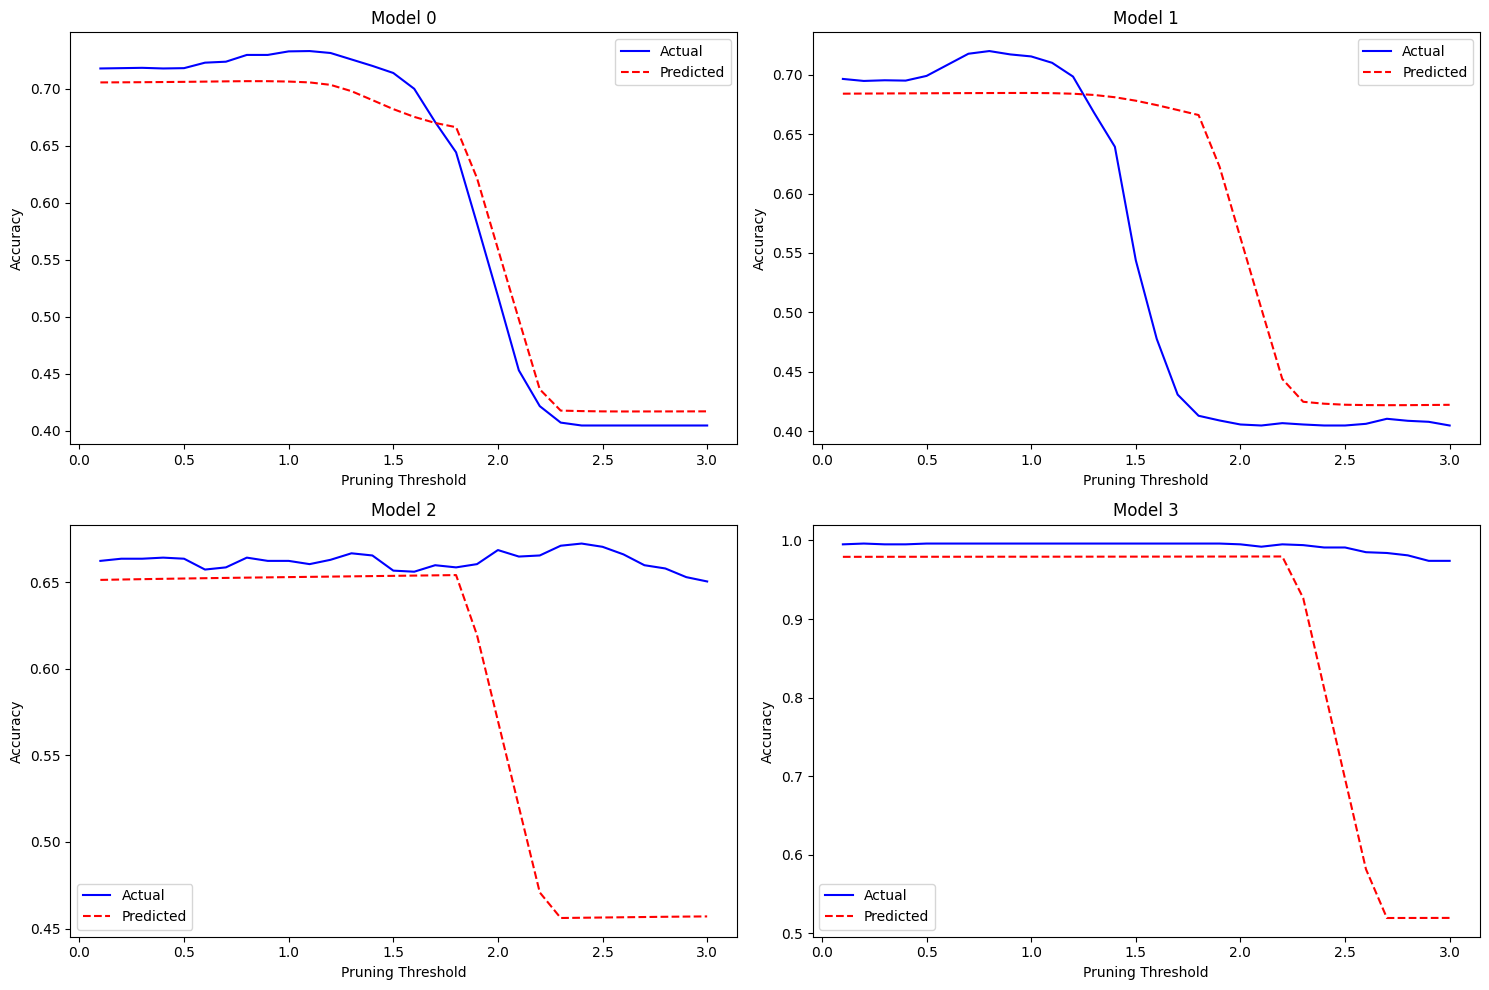

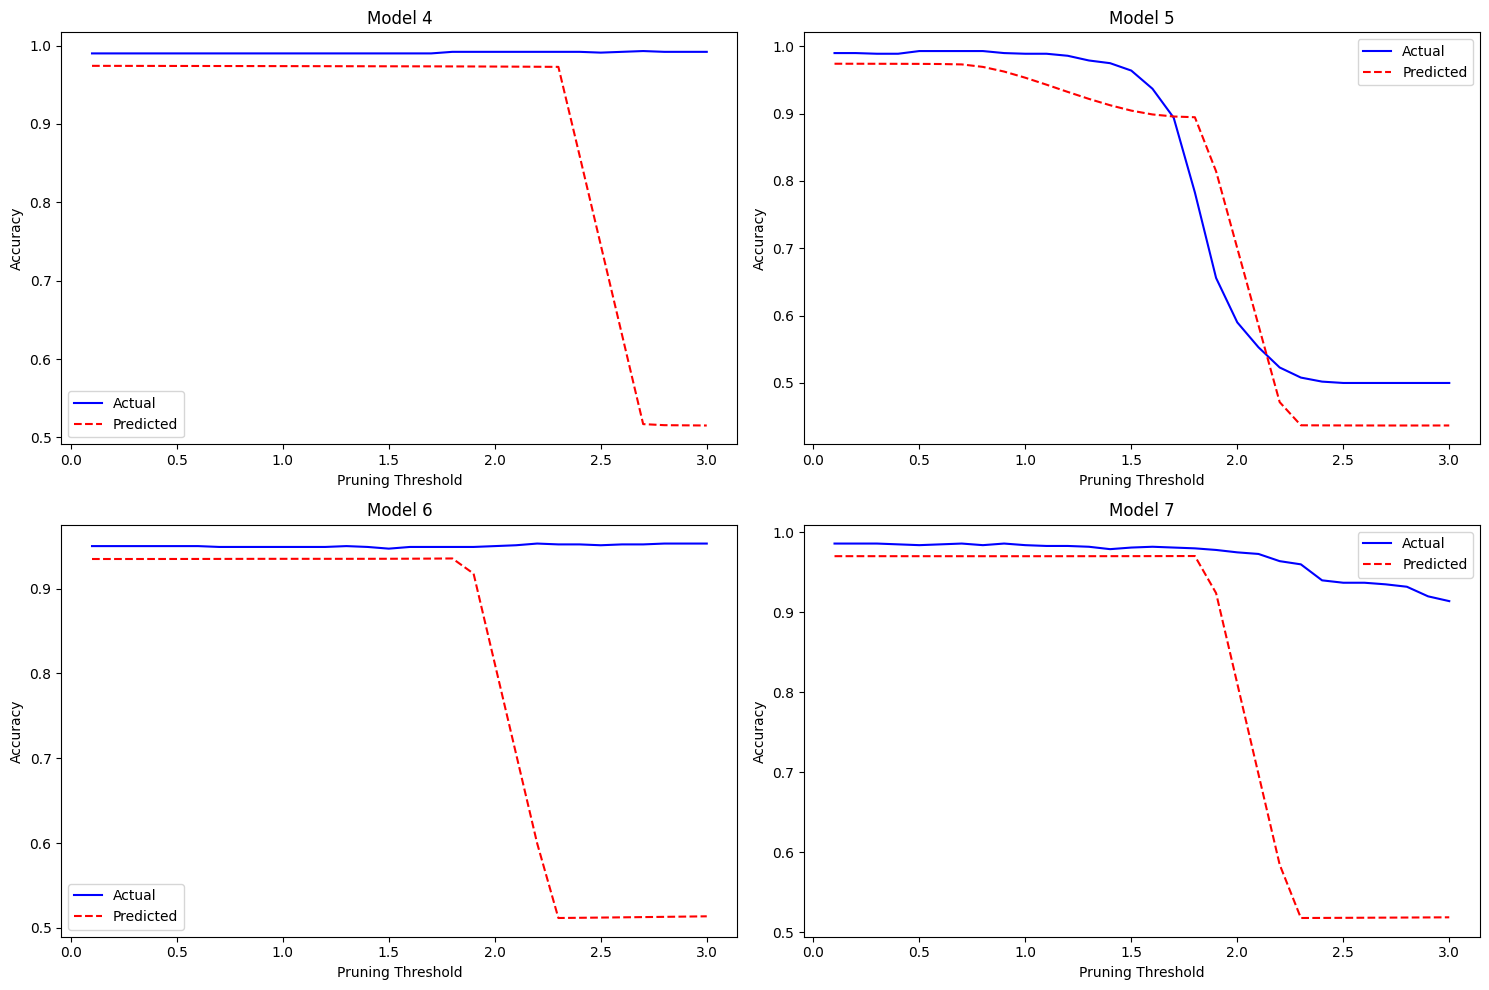

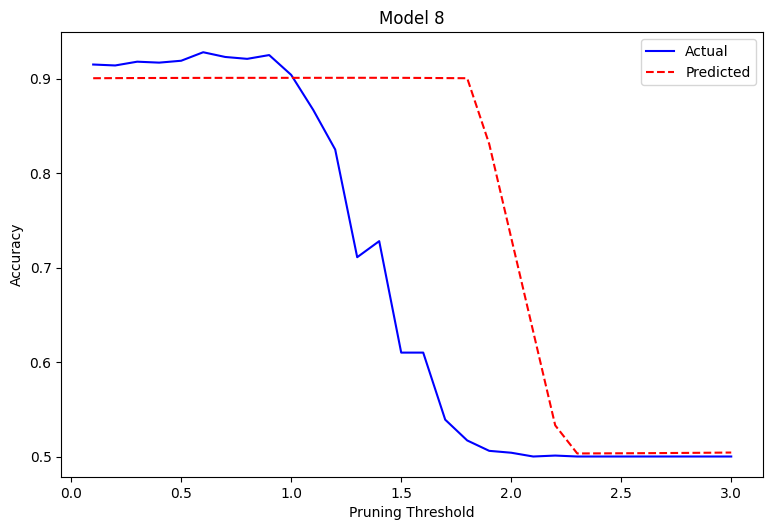

In [34]:
plt.figure(figsize=(15, 10))
for i in range(len(all_model_ids_test)):
    plt.subplot(2, 2, i % 4 + 1)
    plt.plot(all_thresholds, all_actual_curves[i], 'b-', label='Actual')
    plt.plot(all_thresholds, all_predicted_curves[i], 'r--', label='Predicted')
    plt.title(f'Model {all_model_ids_test[i]}')
    plt.xlabel('Pruning Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    
    if (i + 1) % 4 == 0 or i == len(all_model_ids_test) - 1:
        plt.tight_layout()
        plt.show()
        if i < len(all_model_ids_test) - 1:
            plt.figure(figsize=(15, 10))